Audio界的Pillow/Pandas - Librosa

In [1]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

In [2]:
array, sampling_rate

(array([-1.4068211e-03, -4.4607485e-04, -4.1098098e-04, ...,
         7.9623042e-06, -3.0417003e-05,  1.2765069e-05], dtype=float32),
 22050)

**Time series Graph**

In [10]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def show(signal_array, title = None, xrange:tuple = None):
    fig, ax = plt.subplots(figsize = (15,3))
    if title:
        plt.title(title)
    if xrange:
        plt.xlim(*xrange)
    plt.plot(signal_array)
    plt.show()

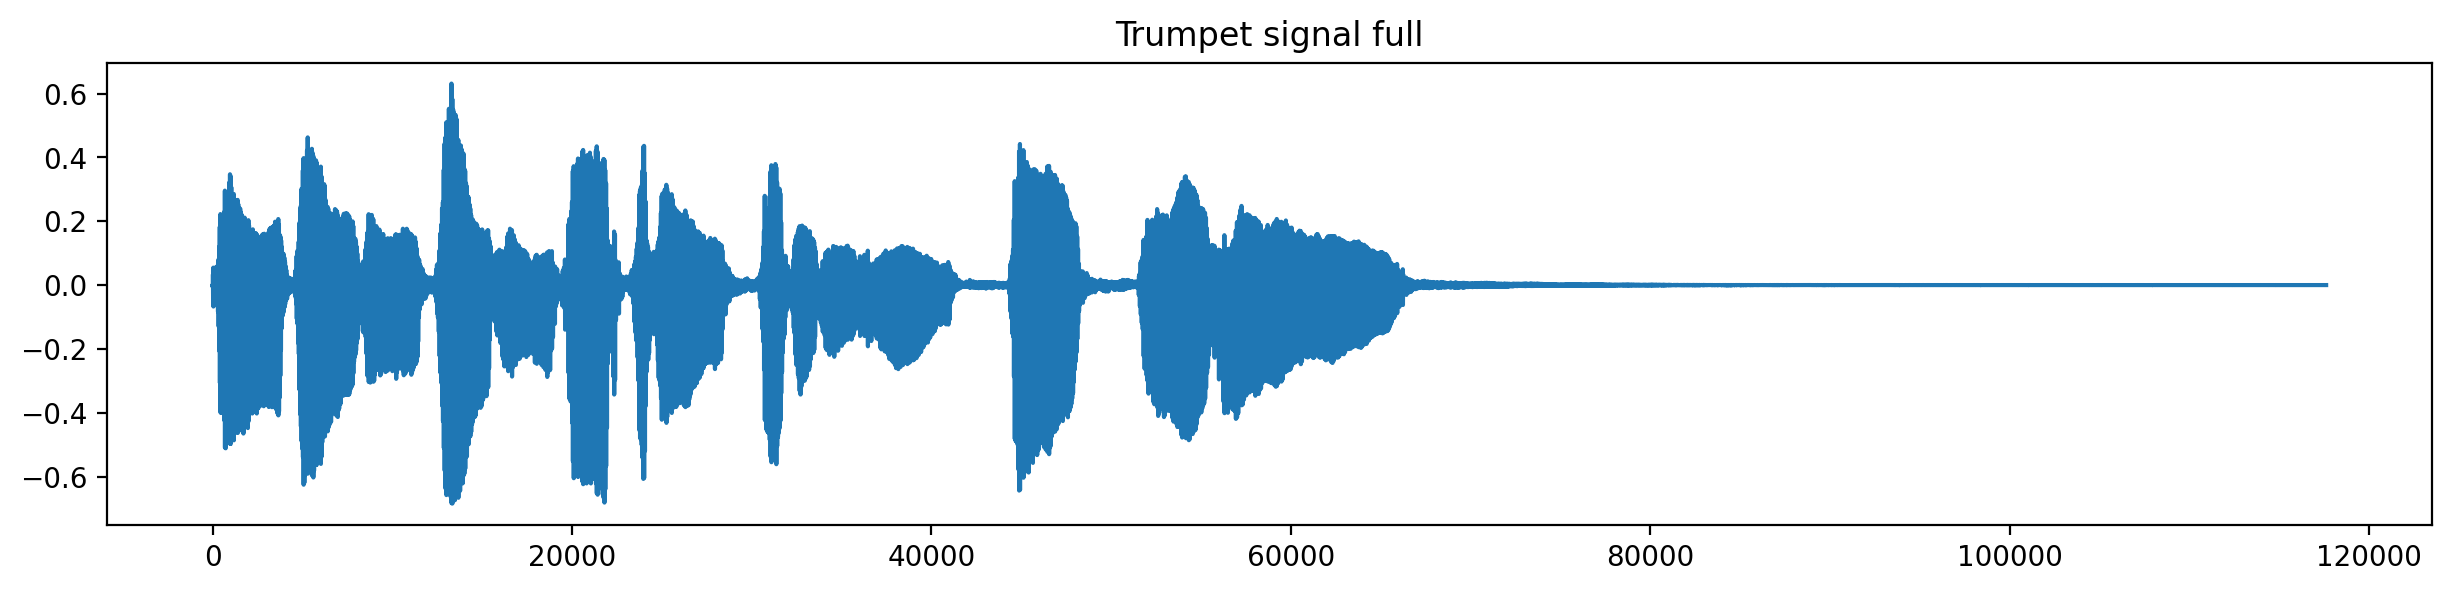

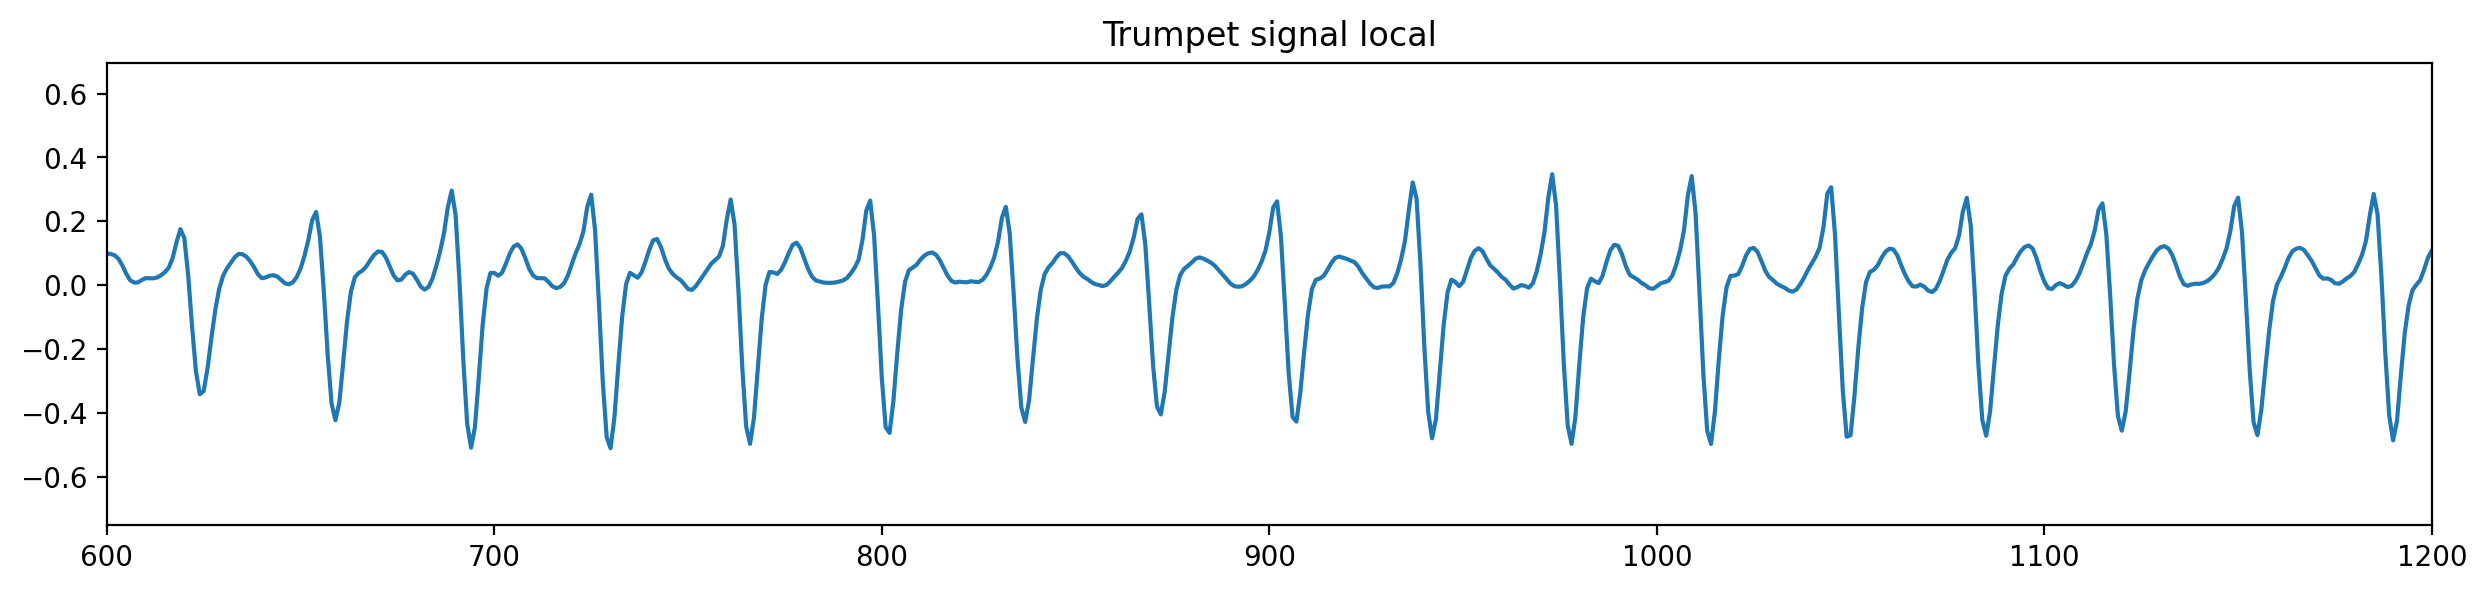

In [11]:
show(array, "Trumpet signal full")
show(array, "Trumpet signal local", (600, 1200))

放到还是可以看到，声音可以表示成一系列的三角级数的叠加

**The frequency spectrum**
1. Transform the original audio signal to a - frequency/amplitude arrays
2. Plot the amplitude of different frequencies appeared in this audio piece.

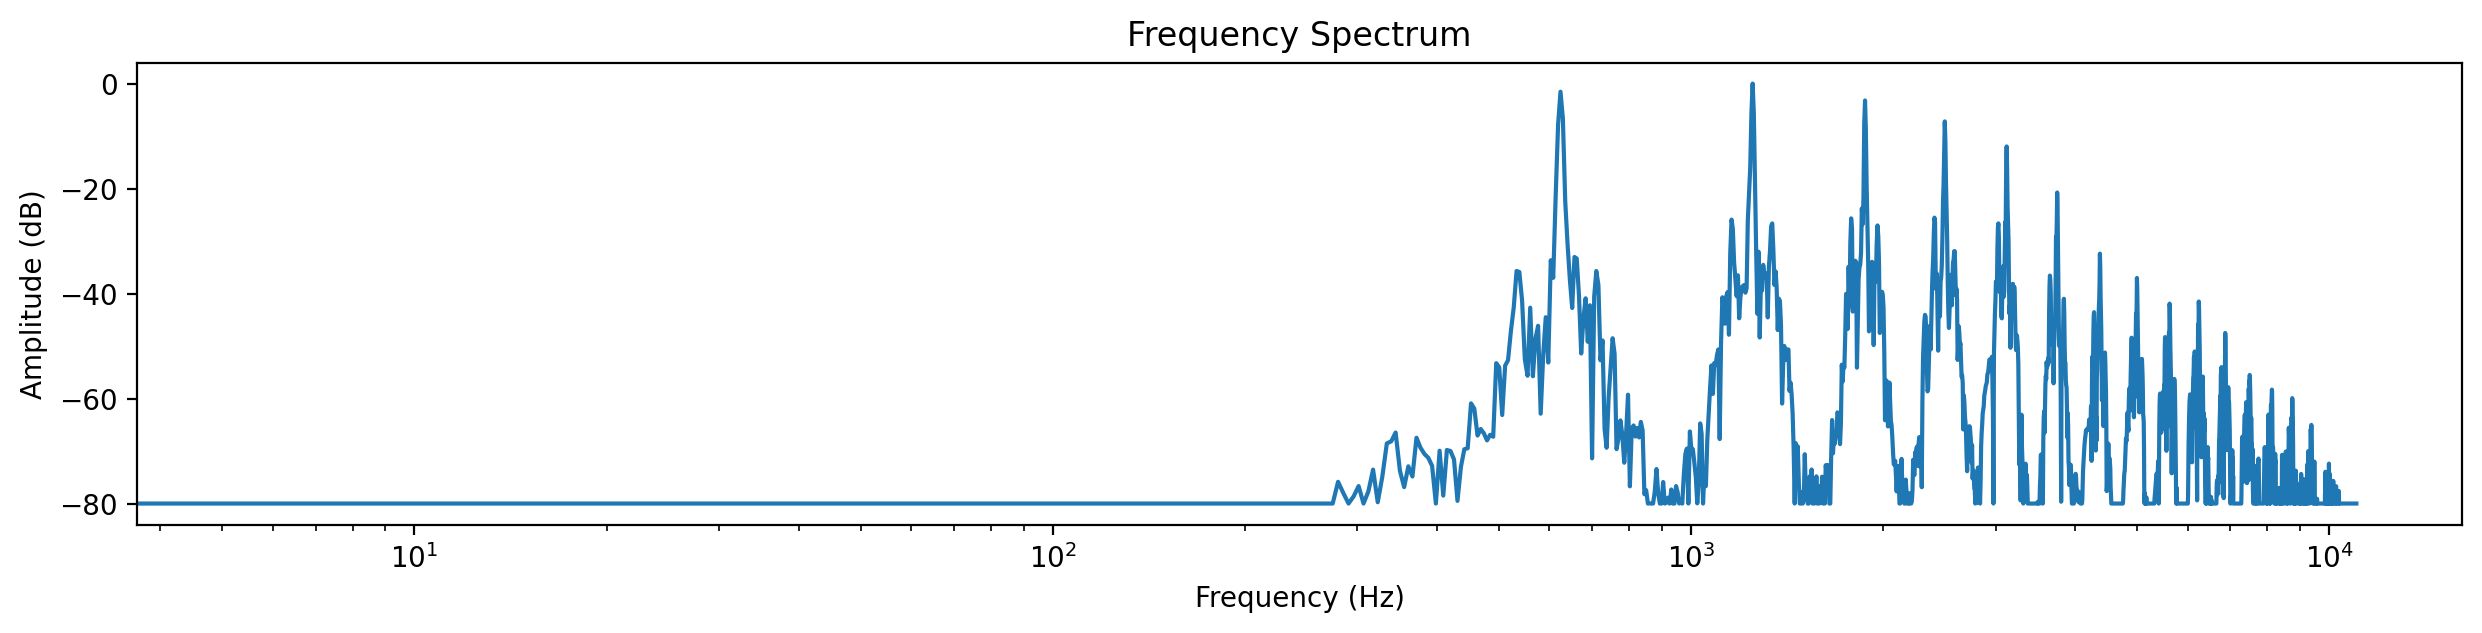

In [5]:
import numpy as np

# 这里的4096个sample也就几毫秒，如果是16000Hz的采样率，那么4096个sample就是0.256秒
# 所以这个frequency spectrum是0.256秒的音频信号的频谱
# 代表一个瞬时的状态
dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

fig, ax = plt.subplots(figsize = (15,3))
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.title("Frequency Spectrum")
plt.xscale("log")

从音乐的角度上来说，这个频谱代表了一个和声，可以理解成最低的一个基频，和更高的泛频，高频的声音强度越来越低。

In [8]:
dft

array([ 8.43816380e-04+0.00000000e+00j, -3.44852086e-04-3.06935268e-04j,
        6.10099698e-05-9.13102971e-05j, ...,
        4.94075746e-07+1.41122484e-07j,  9.15312663e-07-1.09231195e-06j,
       -2.37169385e-06+0.00000000e+00j])

DFT的结果是一个虚数数组， 虚数的模（或称为绝对值）可以使用 Python 的 abs() 函数来计算。虚数 (a + bi) 的模是 ($\sqrt{a^2 + b^2}$),这就代表了振幅（amplitude）， 实部和虚部的夹角叫做相位，一般在机器学习中就舍弃了。 librosa.amplitude_to_db()把振幅转换为分贝。 我们想要计算DFT（离散傅立叶变换），但是在实际应用中，唯一有效的方式是使用FFT(快速傅立叶变换)，所以FFT和DFT在这个情形下经常混着叫，一个东西。    

音频的频谱和信号-时间图是对同一个数据的两种不同的解读方法。一种是看振幅随着时间变化的曲线，另一种是看在一个固定的时间点，不同频率信号的振幅。

**观察单个的频率随时间的变化，怎么搞？- Spectrogram**    
x-axis: 时间          
y-axis: 不同频率的音符            
hue: 声音的强度(db)            

从音乐4要素来说，音高(y轴)， 音值(x轴)， 音量(颜色)， 音色(没有表示), 四要素表现出了3个，这个图还是可以的。

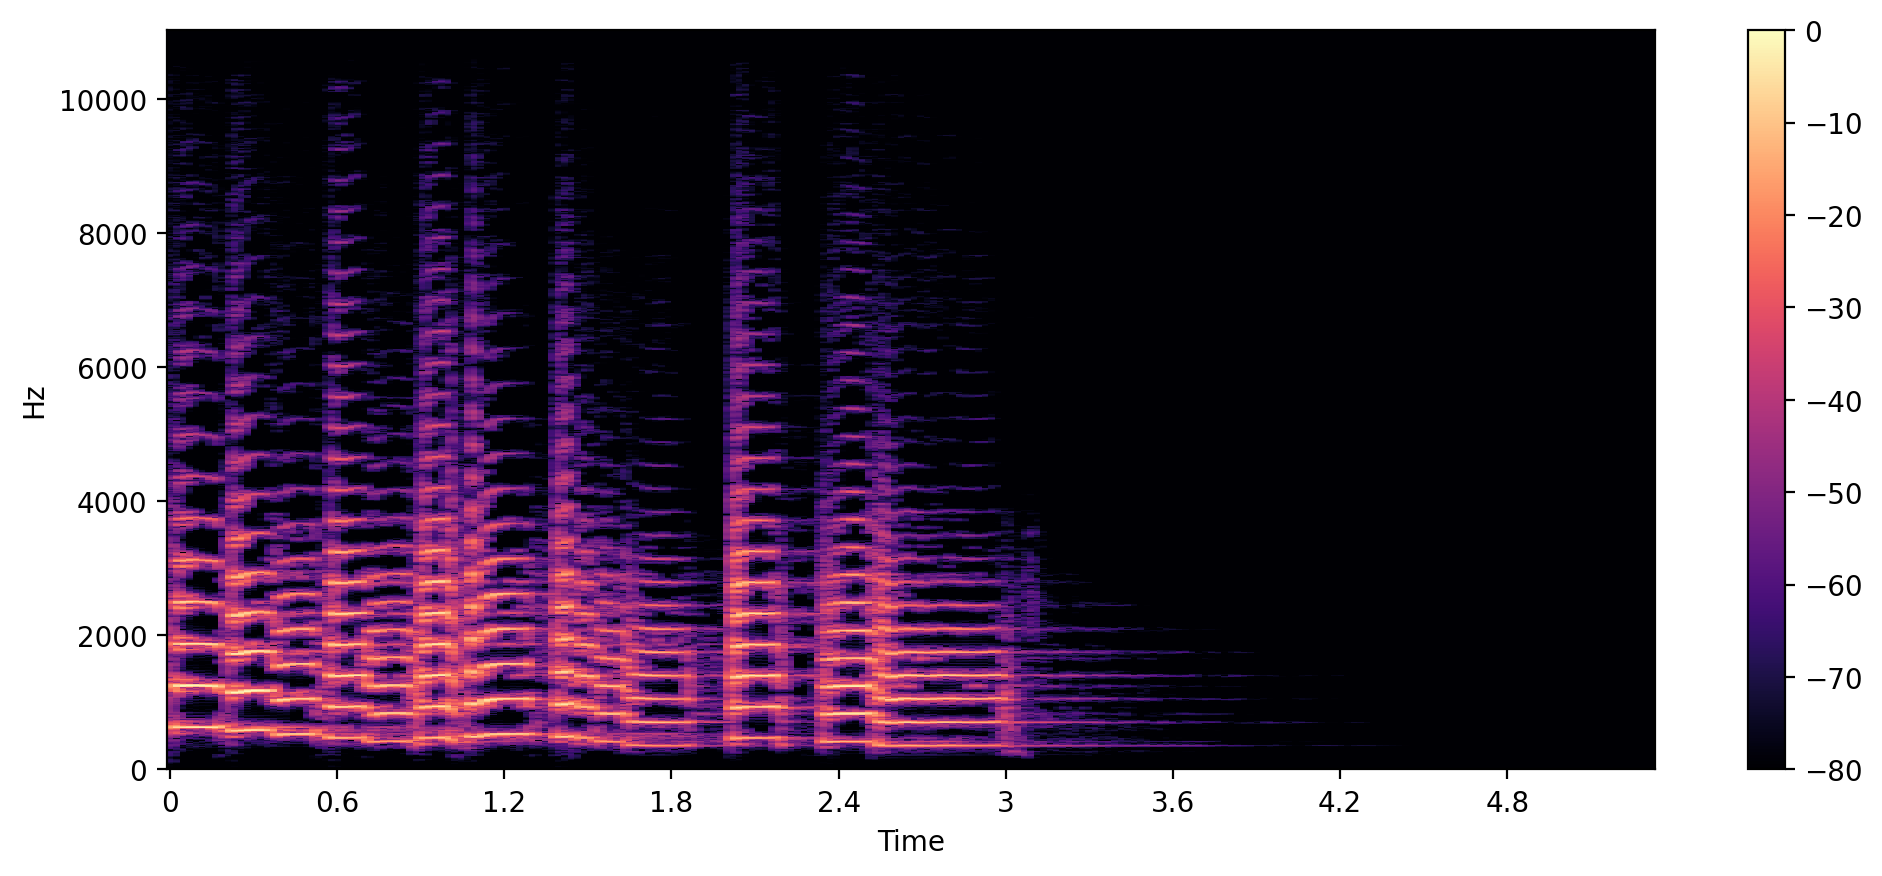

In [13]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

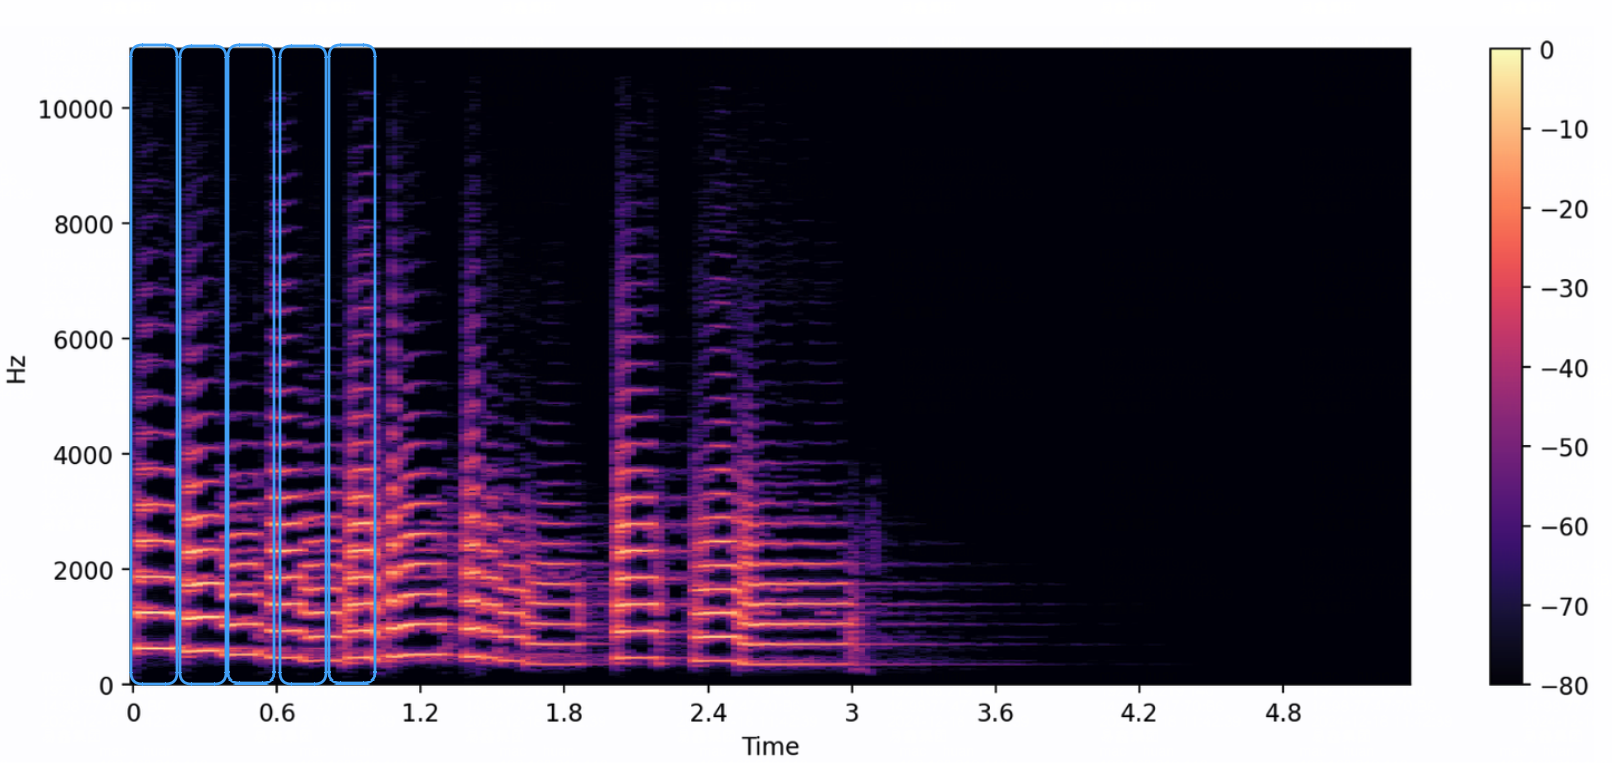

这个的意思就是在时间上，切成很小的片段，分别对每个小片段，计算FFT，得到frequency spectrum,把这些frequency spectrum在时间维度上做一个stakcing，就得到了频率强度随时间变化的曲线。 `librosa.stft()` 把整个音频片段，切分为很多长度为2048的小片段，然后做FFT。有时候我们需要做STFT的反变换，把spectrogram变换回waveform。但是，在STFT的过程中，我们丢失了相位信息。如果spectrogram是由某个深度学习的算法生成的，通常就没有相位信息，我们可能会用到一些相位重建算法，比如Griffin-Lim算法，或者深度学习算法（`Vocoder`），重建相位信息。


> spectrogram不仅是一个可视化的工具，很多的机器学习以spectrogram作为input，然后输出一个spectrogram作为output

In [3]:
from funasr import AutoModel
import soundfile
import os

chunk_size = [0, 10, 5]
encoder_chunk_look_back = 4
decoder_chunk_look_back = 1

model = AutoModel(model="paraformer-zh-streaming")

wav_file = os.path.join(model.model_path, "example/asr_example.wav")
speech, sample_rate = soundfile.read(wav_file)
chunk_stride = chunk_size[1] * 960

cache = {}
total_chunk_num = int(len((speech)-1)/chunk_stride+1)
buffer = ""
for i in range(total_chunk_num):
    speech_chunk = speech[i*chunk_stride:(i+1)*chunk_stride]
    is_final = i == total_chunk_num - 1
    res = model.generate(
        input=speech_chunk, 
        cache=cache, 
        is_final=is_final, 
        chunk_size=chunk_size, 
        encoder_chunk_look_back=encoder_chunk_look_back, 
        decoder_chunk_look_back=decoder_chunk_look_back
    )
    buffer += res[0]['text']

funasr version: 1.2.0.
Check update of funasr, and it would cost few times. You may disable it by set `disable_update=True` in AutoModel
You are using the latest version of funasr-1.2.0


2024-12-19 14:04:11,802 - modelscope - WARNING - Using branch: master as version is unstable, use with caution
rtf_avg: 1.746: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]                                                                                          


In [4]:
model.model_path

'/Users/mac/.cache/modelscope/hub/iic/speech_paraformer-large_asr_nat-zh-cn-16k-common-vocab8404-online'

In [5]:
from dataclasses import dataclass, field
from functools import lru_cache
from funasr import AutoModel
import soundfile
import os

@lru_cache
def load_model():
    return AutoModel(model="paraformer-zh-streaming")

@dataclass
class Paraformer:
    """Usage:
    
    Call the steaming function independently.
    ```python
    paraformer = Paraformer()
    paraformer.stream_asr(
        speech_chunk = speech_chunk,  # pass an np array to paraformer
        is_final = False # whether the current the chunk is the final chunk
    )
    ```
    
    Call the straming function inside a stream.
    ```python
    # define a chunk size
    chunk_stride = 9600
    # initialize parafromer
    paraformer = Paraformer()
    fp = "../datafiles/asr_example.wav"
    speech, sample_rate = soundfile.read(fp)
    total_chunk_num = int(len((speech)-1)/chunk_stride+1)
    buffer = ""

    # chunk the wav file
    for i in range(total_chunk_num):
        use paraformer on the current chunk
        res = paraformer.stream_asr(
            speech[i*chunk_stride:(i+1)*chunk_stride], 
            i == total_chunk_num - 1
        )
        buffer += res
    
    ```
    
    """
    chunk_size: list = field(default_factory=lambda: [0, 10, 5])
    encoder_chunk_look_back: int = 4
    decoder_chunk_look_back: int = 1
    
    def __post_init__(self):
        self.model = load_model()
        self.cache = {}
        
    def stream_asr(self, speech_chunk:list, is_final:bool = False):
        if isinstance(speech_chunk, list):
            speech_chunk = np.array(speech_chunk)
            
        return self.model.generate(
            input=speech_chunk, 
            cache=self.cache, 
            is_final=is_final, 
            chunk_size=self.chunk_size, 
            encoder_chunk_look_back=self.encoder_chunk_look_back, 
            decoder_chunk_look_back=self.decoder_chunk_look_back
        )[0]['text']

In [9]:
!ls /Users/mac/.cache/modelscope/hub/iic/speech_paraformer-large_asr_nat-zh-cn-16k-common-vocab8404-online/example/asr_example.wav

asr_example.wav


In [11]:
!cp /Users/mac/.cache/modelscope/hub/iic/speech_paraformer-large_asr_nat-zh-cn-16k-common-vocab8404-online/example/asr_example.wav .

In [ ]:
paraformer = Paraformer()
paraformer.stream_asr(
        speech_chunk = speech_chunk,  # pass an np array to paraformer
        is_final =False # whether the current the chunk is the final chunk
    )

In [12]:
chunk_stride = 9600
paraformer = Paraformer()
fp = "../datafiles/asr_example.wav"
speech, sample_rate = soundfile.read(fp)
total_chunk_num = int(len((speech)-1)/chunk_stride+1)
buffer = ""

for i in range(total_chunk_num):
    res = paraformer.stream_asr(
        speech[i*chunk_stride:(i+1)*chunk_stride], 
        i == total_chunk_num - 1
    )
    buffer += res

rtf_avg: 1.306: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]                                                                                          


In [14]:
from funasr import AutoModel

model = AutoModel(model="iic/punc_ct-transformer_zh-cn-common-vad_realtime-vocab272727")

inputs = "欢迎体验这个|阿里巴巴|这个达摩院的|大模型|总的来说|这个大模型还是不错的|真的很好了|希望大家喜欢|我说完了|哈哈|"
vads = inputs.split("|")
rec_result_all = "outputs: "
cache = {}
for vad in vads:
    rec_result = model.generate(input=vad, cache=cache)
    rec_result_all += rec_result[0]["text"]
print(rec_result_all)

funasr version: 1.2.0.
Check update of funasr, and it would cost few times. You may disable it by set `disable_update=True` in AutoModel
You are using the latest version of funasr-1.2.0


2024-12-19 16:47:53,267 - modelscope - WARNING - Using branch: master as version is unstable, use with caution
rtf_avg: -0.007: 100%|██████████| 1/1 [00:00<00:00, 132.17it/s]                                                                                  

outputs: 欢迎体验这个阿里巴巴这个达摩院的大模型。总的来说，这个大模型还是不错的，真的很好了。希望大家喜欢我说完了哈哈


In [13]:
import sys
sys.path.append("../")
from punctuations import PuncCreator
punc = PuncCreator()
punc.create_punc("欢迎体验这个阿里巴巴这个达摩院的大模型总的来说这个大模型还是不错的真的很好了希望大家喜欢我说完了哈哈")

funasr version: 1.2.0.
Check update of funasr, and it would cost few times. You may disable it by set `disable_update=True` in AutoModel
You are using the latest version of funasr-1.2.0


2024-12-19 16:45:15,888 - modelscope - WARNING - Using branch: master as version is unstable, use with caution
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/j6/f80xln3917v1vnxzy9sqw6v40000gn/T/jieba.cache
DEBUG:jieba:Loading model from cache /var/folders/j6/f80xln3917v1vnxzy9sqw6v40000gn/T/jieba.cache
Loading model cost 0.381 seconds.
DEBUG:jieba:Loading model cost 0.381 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
rtf_avg: -0.203: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]                                                                                  


'欢迎体验这个阿里巴巴这个达摩院的大模型。总的来说，这个大模型还是不错的，真的很好了。希望大家喜欢我说完了哈哈。'